In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aysen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aysen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aysen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Function for text preprocessing
def preprocess_text(text):

    # Remove digits
    text = text.replace('\d+', '')
    
    # Clean urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)
    
    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords and non-alphanumeric characters
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [6]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        new_words.append(new_word)
    return new_words

In [7]:
# Load datasets
train_df = pd.read_csv('C:\\Users\\aysen\\Desktop\\hate_speech\\data\\annotations_metadata_train.csv')
test_df = pd.read_csv('C:\\Users\\aysen\\Desktop\\hate_speech\\data\\annotations_metadata_test.csv')

# Text preprocessing
train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)
test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

train_df['preprocessed_text'] = remove_punctuation(train_df['preprocessed_text'])
test_df['preprocessed_text'] = remove_punctuation(test_df['preprocessed_text'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features based on your dataset size
X_train = vectorizer.fit_transform(train_df['preprocessed_text']).toarray()
X_val = vectorizer.transform(val_df['preprocessed_text']).toarray()
X_test = vectorizer.transform(test_df['preprocessed_text']).toarray()
y_train = (train_df['label'] == 'hate').astype(int).values
y_val = (val_df['label'] == 'hate').astype(int).values
y_test = (test_df['label'] == 'hate').astype(int).values

In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [10]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

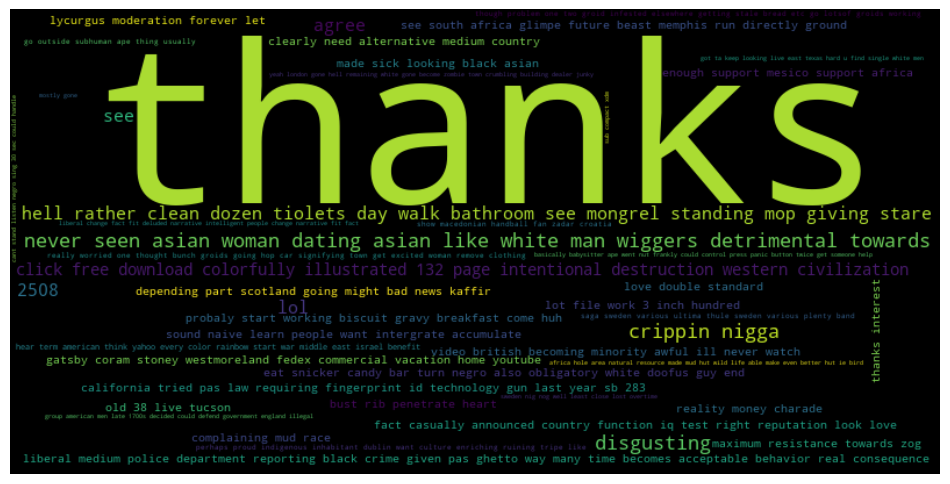

In [11]:
from wordcloud import WordCloud
#Frequency of words
fdist = FreqDist(train_df['preprocessed_text'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Define the Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [13]:
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 2000)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(2000, 500)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(500, 100)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(100, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [14]:
# Instantiate the model
input_size = X_train.shape[1]
print ("Input size:", input_size)
hidden_size = 1000
output_size = 1  # Binary classification
model = SimpleNN(input_size, hidden_size, output_size)

Input size: 4370


In [15]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop with validation
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
        print(f'Epoch: {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')


Epoch: 1, Training Loss: 0.6299775242805481, Validation Loss: 0.6396833062171936
Epoch: 2, Training Loss: 0.36663147807121277, Validation Loss: 0.5321643352508545
Epoch: 3, Training Loss: 0.12598420679569244, Validation Loss: 0.5904771685600281
Epoch: 4, Training Loss: 0.058775894343853, Validation Loss: 0.6562259197235107
Epoch: 5, Training Loss: 0.06667385995388031, Validation Loss: 0.719184160232544


In [17]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze().numpy()

y_pred_test_binary = (y_pred_test > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred_test_binary)

print(f"Testing Accuracy: {test_accuracy}")

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test_binary))

Testing Accuracy: 0.6903765690376569
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       239
           1       0.69      0.70      0.69       239

    accuracy                           0.69       478
   macro avg       0.69      0.69      0.69       478
weighted avg       0.69      0.69      0.69       478

